## Churn Prediction - Imbalanced Data 

- Predict probabilities for each class by deploying    
    Pipeline, ColumnTransformer, Voting Classifier    
    and robust machine learning models

## 1 Import libraries & data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = 10, 6

## 2 Data Preprocessing

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [4]:
# for column in train[['Age', 'HasCrCard', 'IsActiveMember']]:
#     if train[column].dtype == 'float64':
#         train[column] = train[column].astype('int64')

In [5]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

>***Observations:***

The classes are imbalanced. There are many methods to deal with them.    
Here we will deploy models that are robust to imbalanced classification problems.

In [7]:
# Split the train data into train & evl sets & 
# keep test data as test set
X = train.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = train['Exited']

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [8]:
# Use ColumnTransformer by the column types
numeric_cols = X.select_dtypes(include='number').columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

catogorical_cols = X.select_dtypes(include='object').columns
catogorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('selector', SelectPercentile(chi2, percentile=50))
])

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', catogorical_transformer, catogorical_cols)
    ]
)

## 3 Classification Models

### 3.1 Create Pipeline

In [10]:
# Define the classifier
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train and evaluate Logistic Regression
lr_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7b299ed24d30>))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [11]:
y_pred_lr = lr_clf.predict(X_eval)
print(f'Logistic Regression Accuracy: {accuracy_score(y_eval, y_pred_lr):.3f}')

Logistic Regression Accuracy: 0.833


In [12]:
# Define the second classifier (Random Forest)
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Train and evaluate Random Forest
rf_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7b299ed24d30>))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [13]:
y_pred_rf = rf_clf.predict(X_eval)
print(f'Random Forest Accuracy: {accuracy_score(y_eval, y_pred_rf):.3f}')

Random Forest Accuracy: 0.859


In [14]:
# predict class probabilities for all classifiers
y_probas = [c.fit(X_train, y_train).predict_proba(X_eval) for c in (lr_clf, rf_clf)]
y_probas

[array([[0.75800066, 0.24199934],
        [0.96970797, 0.03029203],
        [0.40153953, 0.59846047],
        ...,
        [0.75156946, 0.24843054],
        [0.91682191, 0.08317809],
        [0.11576157, 0.88423843]]),
 array([[0.96      , 0.04      ],
        [0.9       , 0.1       ],
        [0.13666667, 0.86333333],
        ...,
        [0.66      , 0.34      ],
        [0.98      , 0.02      ],
        [0.63      , 0.37      ]])]

In [15]:
# extracts the probabilities for the positive class from lr_clf array.
print(y_probas[0][:, 1])

# extracts the probabilities for the positive class from rf_clf array.
print(y_probas[1][:, 1])

[0.24199934 0.03029203 0.59846047 ... 0.24843054 0.08317809 0.88423843]
[0.04       0.1        0.86333333 ... 0.34       0.02       0.37      ]


In [16]:
# predict class probabilities for the positive class from lr_clf
y_probas_lr = lr_clf.predict_proba(X_eval)[:, 1]
y_probas_lr

array([0.24199934, 0.03029203, 0.59846047, ..., 0.24843054, 0.08317809,
       0.88423843])

In [17]:
# roc_auc_lr = roc_auc_score(y_test, y_probas[0].tolist())
roc_auc_lr = roc_auc_score(y_eval, y_probas_lr)
print(f'ROC_AUC Score: {roc_auc_lr:.3f}')

ROC_AUC Score: 0.815


In [18]:
# predict class probabilities for the positive class from rf_clf
y_probas_rf = rf_clf.predict_proba(X_eval)[:, 1]
y_probas_rf

array([0.04      , 0.1       , 0.86333333, ..., 0.34      , 0.02      ,
       0.37      ])

In [19]:
# roc_auc_rf = roc_auc_score(y_test, y_probas[0].tolist())
roc_auc_rf = roc_auc_score(y_eval, y_probas_rf)
print(f'ROC_AUC Score: {roc_auc_rf:.3f}')

ROC_AUC Score: 0.873


In [20]:
# Compute ROC-AUC for each classifier
roc_auc_scores = []
for probas in y_probas:
    roc_auc = roc_auc_score(y_eval, probas[:, 1])
    roc_auc_scores.append(roc_auc)

# Print the ROC-AUC scores
for i, roc_auc in enumerate(roc_auc_scores):
    print(f'Classifier {i + 1} ROC-AUC: {roc_auc:.3f}')

Classifier 1 ROC-AUC: 0.815
Classifier 2 ROC-AUC: 0.873


### 3.2 Deploy Voting Classifier

#### 3.2.1 'hard' method - majority voting

In [21]:
# Define the classifiers
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Create a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_clf),
    ('rf', rf_clf)
], voting='hard')  # 'hard' means majority voting

# Train and evaluate the VotingClassifier
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('e...
                                                                                Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('encoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore')),
                                                                                                ('selector',
                                                                                                 SelectPercentile(percentile=50,
                                                                                                                  score_func=<function chi2 at 0x7b299ed24d30>))]),
                                                                                Index(['Geography', 'Gender'], dtype='object'))])),
                                              ('classifier',
                                               RandomForestClassifier())]))])

In [22]:
y_pred_voting = voting_clf.predict(X_eval)
print(f'Voting Classifier Accuracy: {accuracy_score(y_eval, y_pred_voting):.3f}')

Voting Classifier Accuracy: 0.839


#### 3.2.2 'soft' method - sum the probabilities for each class

In [23]:
# Define the classifiers
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Create a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_clf),
    ('rf', rf_clf)
], voting='soft')  # sum the probabilities for each class

# Train and evaluate the VotingClassifier
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('e...
                                                                                Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('encoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore')),
                                                                                                ('selector',
                                                                                                 SelectPercentile(percentile=50,
                                                                                                                  score_func=<function chi2 at 0x7b299ed24d30>))]),
                                                                                Index(['Geography', 'Gender'], dtype='object'))])),
                                              ('classifier',
                                               RandomForestClassifier())]))],
                 voting='soft')

In [24]:
# Make predictions on the evaluation set
y_pred_voting = voting_clf.predict(X_eval)
# y_pred_voting
print(f'Voting Classifier Accuracy: {accuracy_score(y_eval, y_pred_voting):.3f}')

Voting Classifier Accuracy: 0.852


### 3.3 Plot ROC curves & TradeOff curves   
https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py

In [25]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

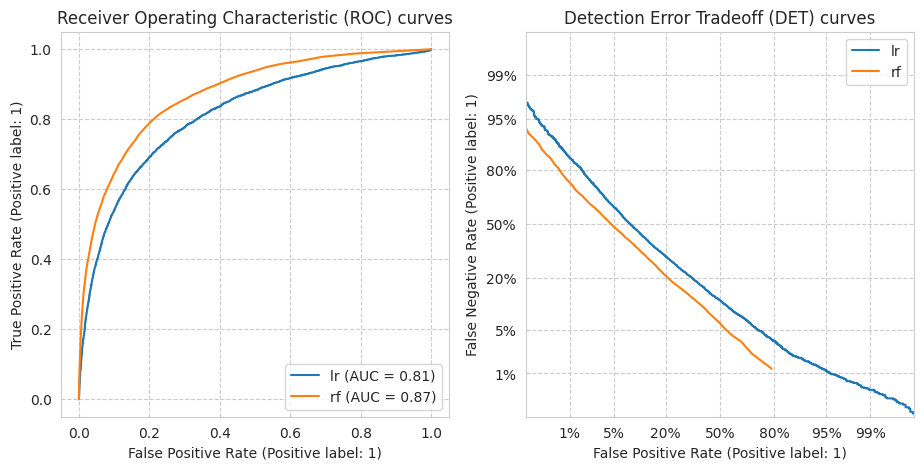

In [26]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in voting_clf.estimators:
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_eval, y_eval, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_eval, y_eval, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### 3.4 Predict probabilities for each class

In [27]:
y_probas_voting = voting_clf.predict_proba(X_eval)[:, 1]
y_probas_voting

array([0.16599967, 0.05514601, 0.72423024, ..., 0.28921527, 0.06158905,
       0.64961921])

In [28]:
roc_auc_voting = roc_auc_score(y_eval, y_probas_voting)
print(f'ROC_AUC Score: {roc_auc_voting:.3f}')

ROC_AUC Score: 0.874


In [29]:
# Predict the probability for the target variable Exited of the test set
X_test = test.drop(['id', 'CustomerId', 'Surname'], axis=1) 

test_predict_probas = voting_clf.predict_proba(X_test)[:, 1] # tpr = 1

submission_df = pd.DataFrame({'id': test['id'], 
                            'Exited': test_predict_probas})
submission_df

,id,Exited
0,0,0.041753
1,1,0.011422
2,2,0.078447
3,3,0.044814
4,4,0.009797
...,...,...
165029,165029,0.084182
165030,165030,0.175633
165031,165031,0.050003
165032,165032,0.040341


In [30]:
# submission_df.to_csv('submission.csv', index=None)

## 4 Boosting Models

In [31]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 4.1 Create Pipeline

In [32]:
# Define the classifier
gb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Train and evaluate Random Forest
gb_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7b299ed24d30>))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier', GradientBoostingClassifier())])

In [33]:
y_pred_gb = gb_clf.predict(X_eval)
print(f'Gradient Boosting Accuracy: {accuracy_score(y_eval, y_pred_gb):.3f}')

Gradient Boosting Accuracy: 0.863


In [34]:
# Define the classifier
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Train and evaluate Logistic Regression
xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknow...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [35]:
y_pred_xgb = xgb_clf.predict(X_eval)
print(f'XGBClassifier Accuracy: {accuracy_score(y_eval, y_pred_xgb):.3f}')

XGBClassifier Accuracy: 0.864


In [36]:
# predict class probabilities for all classifiers
y_probas = [c.fit(X_train, y_train).predict_proba(X_eval) for c in (gb_clf, xgb_clf)]
y_probas

[array([[0.88855048, 0.11144952],
        [0.88352697, 0.11647303],
        [0.28747653, 0.71252347],
        ...,
        [0.7594131 , 0.2405869 ],
        [0.9763146 , 0.0236854 ],
        [0.56774638, 0.43225362]]),
 array([[0.9379902 , 0.0620098 ],
        [0.8707081 , 0.1292919 ],
        [0.23112977, 0.76887023],
        ...,
        [0.84165907, 0.15834093],
        [0.9844897 , 0.01551031],
        [0.37955248, 0.6204475 ]], dtype=float32)]

In [37]:
# extracts the probabilities for the positive class from gb_clf array.
print(y_probas[0][:, 1])

# extracts the probabilities for the positive class from xgb_clf array.
print(y_probas[1][:, 1])

[0.11144952 0.11647303 0.71252347 ... 0.2405869  0.0236854  0.43225362]
[0.0620098  0.1292919  0.76887023 ... 0.15834093 0.01551031 0.6204475 ]


In [38]:
# predict class probabilities for the positive class from gb_clf
y_probas_gb = gb_clf.predict_proba(X_eval)[:, 1]
y_probas_gb

array([0.11144952, 0.11647303, 0.71252347, ..., 0.2405869 , 0.0236854 ,
       0.43225362])

In [39]:
# roc_auc_gb = roc_auc_score(y_eval, y_probas[0].tolist())
roc_auc_gb = roc_auc_score(y_eval, y_probas_gb)
print(f'ROC_AUC Score: {roc_auc_gb:.3f}')

ROC_AUC Score: 0.888


In [40]:
# predict class probabilities for the positive class from xgb_clf
y_probas_xgb = xgb_clf.predict_proba(X_eval)[:, 1]
y_probas_xgb

array([0.0620098 , 0.1292919 , 0.76887023, ..., 0.15834093, 0.01551031,
       0.6204475 ], dtype=float32)

In [41]:
roc_auc_xgb = roc_auc_score(y_eval, y_probas_xgb)
print(f'ROC_AUC Score: {roc_auc_xgb:.3f}')

ROC_AUC Score: 0.886


In [42]:
# Compute ROC-AUC for each classifier
roc_auc_scores = []
for probas in y_probas:
    roc_auc = roc_auc_score(y_eval, probas[:, 1])
    roc_auc_scores.append(roc_auc)

# Print the ROC-AUC scores
for i, roc_auc in enumerate(roc_auc_scores):
    print(f'Classifier {i + 1} ROC-AUC: {roc_auc:.3f}')

Classifier 1 ROC-AUC: 0.888
Classifier 2 ROC-AUC: 0.886


### 4.2 Deploy Voting Classifier

In [43]:
# Define the classifiers
gb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])
    
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Create a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], voting='soft')  # sum the probabilities for each class

# Train and evaluate the VotingClassifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gb',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('e...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))],
                 voting='soft')

In [44]:
y_pred_voting = voting_clf.predict(X_eval)
print(f'Voting Classifier Accuracy: {accuracy_score(y_eval, y_pred_voting):.3f}')

Voting Classifier Accuracy: 0.864


### 4.3 Plot ROC curves & TradeOff curves   
https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py

In [45]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

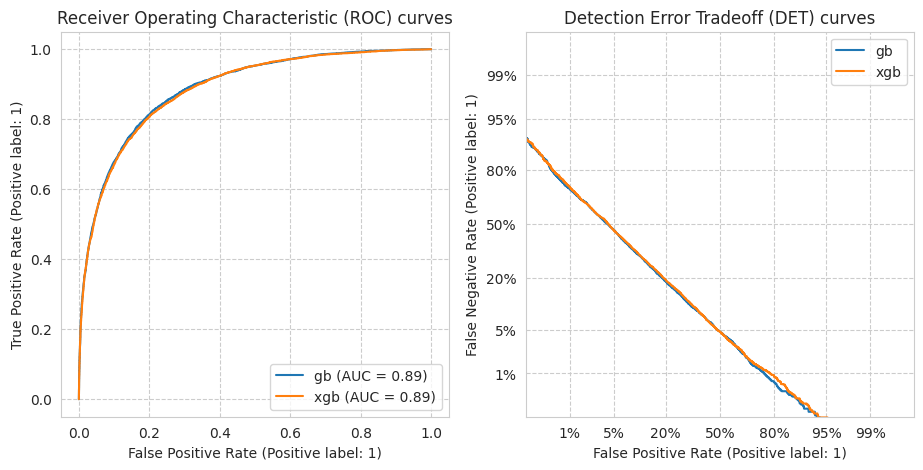

In [46]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in voting_clf.estimators:
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_eval, y_eval, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_eval, y_eval, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### 4.4 Predict probabilities for each class

In [47]:
# predict class probabilities for all classifiers
# probas = [c.fit(X_train, y_train).predict_proba(X_eval) for c in (gb_clf, xgb_clf)]
probas_voting = voting_clf.predict_proba(X_eval)[:, 1]
probas_voting

array([0.08672966, 0.12288247, 0.74069685, ..., 0.19946391, 0.01959786,
       0.52635057])

In [48]:
roc_auc_voting = roc_auc_score(y_eval, y_probas_voting)
print(f'ROC_AUC Score: {roc_auc_voting:.3f}')

ROC_AUC Score: 0.874


In [49]:
# Predict the probability for the target variable Exited of the test set
X_test = test.drop(['id', 'CustomerId', 'Surname'], axis=1) 

test_predict_probas = voting_clf.predict_proba(X_test)[:, 1] # tpr = 1

submission_df = pd.DataFrame({'id': test['id'], 
                            'Exited': test_predict_probas})
submission_df

,id,Exited
0,0,0.016264
1,1,0.009692
2,2,0.040150
3,3,0.043000
4,4,0.011315
...,...,...
165029,165029,0.139336
165030,165030,0.282083
165031,165031,0.086320
165032,165032,0.078992


In [50]:
submission_df.to_csv('submission.csv', index=None)

>**References:**

Column Transformer with Mixed Types    
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

sklearn.ensemble.VotingClassifier   
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

Plot class probabilities calculated by the VotingClassifier¶   
https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html#sphx-glr-auto-examples-ensemble-plot-voting-probas-py

sklearn.metrics.roc_curve   
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

Plot ROC curves & TradeOff curves - Binary Class     
https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py